# Creation ontologies

Here, we create ontologies of the items contained in the scales using different language models.

We have data on participants responding to PID and NEO questionnaire. We embed the individual items of the questionnaire, and compare the semantic similarity of scale items encoded in the emebddings with the correlation of the answers given by participants to these same items.

In [ ]:
import pandas as pd
import numpy as np
import phate
import scipy.spatial.distance as distance

# load scales data
data = pd.read_csv('scales_data.csv')

# select the columns of the dataframe data where the column names starts with "PID" or "NEO"
data = data[data.columns[data.columns.str.startswith('PID') | data.columns.str.startswith('NEO')]]

# form the correlation matrix of the scales data
corr_mx = data.corr().values
corr_values = distance.squareform(1 - corr_mx)

# extract the upper triangle of a matrix into a vector
def extract_upper_triangle(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, 1)]
corr_values = extract_upper_triangle(corr_mx)

## OpenAI

We use here OPenAI's embeddings to create an ontology of the PIDs and NEO items. OpenAI offers two models: small and large. The differences in performance between them are small, but large appears to do slightly better. Here, the large data are used.

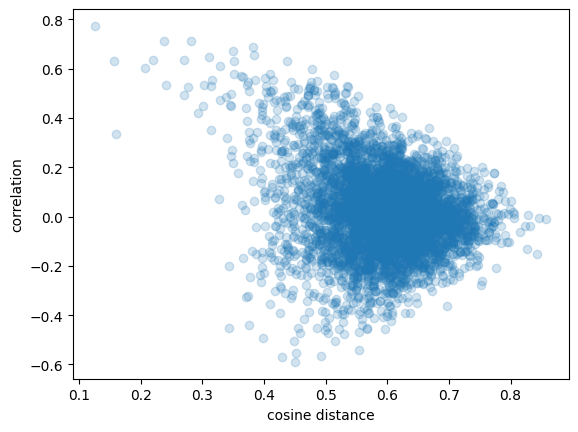

In [ ]:
# Here the scaled with the embeddings are loaded. Change the file to load
# embeddings from a different language model.
scales = pd.read_csv('scales_openAI_large.csv')

# select the rows of scales where the scaleID field is "NEO" or "PID"
scales = scales[scales['scaleID'].isin(['NEO', 'PID'])]

# form matrix of embeddings
mx = scales.embedding.apply(eval).to_list()
mx = np.asarray(mx)

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(mx, metric='cosine')
dist_mx = distance.squareform(dist_values)

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()


We can see that item pairs that have a small cosine distance (i.e. are similar) also have a high correlation. A cosine distance of 0.2 or lower is a guarantee that responses are correlated with a coefficient of 0.6 or more. There are also some item pairs with relatively small distance that have a negative correlation, but we note that the NEO goes in the opposite direction than the PID except for neuroticism.

What is of interest from the standpoint of the scales, however, is to assess the extent to which the two scales are semantically related. For this, we only consider the distance between items of the first and the second scale, rather than all scale items with each other.

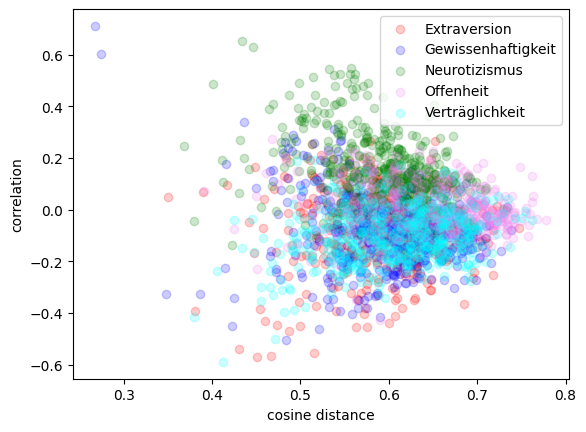

In [ ]:
# select rows of mx where scales.scaleID is "NEO"
neo_idx = scales['scaleID'] == 'NEO'
pid_idx = scales['scaleID'] == 'PID'
neo_mx = mx[neo_idx, :]
pid_mx = mx[pid_idx, :]
cdist_mx = distance.cdist(neo_mx, pid_mx, metric='cosine')
ccorr_mx = corr_mx[np.ix_(neo_idx,pid_idx)]

# create a scatter plot of cdist_mx and ccorr_mx
import matplotlib.pyplot as plt
neo_types = pd.Categorical(scales[neo_idx]['type'].values)
colors = ['red', 'blue', 'green', 'violet', 'cyan']
for neoscale, color in zip(neo_types.categories, colors):
    neo_type_idx = neo_types == neoscale
    plt.scatter(cdist_mx[neo_type_idx,:].flatten(), ccorr_mx[neo_type_idx,:].flatten(),
                alpha = 0.2, c = color, label = neoscale)
plt.legend(loc = 1)

plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()


We see here that, as the semantic similarity increases (lower cosine distances between the language model embeddings), the correlation can take considerable values, although there are also cases where the correlation is low and the distance is lower than that. Cosine distances of 0.6 or more are required to keep the correlation within the +-0.2 boundaries.

Furthermore, we see that many points showing a positive correlation with the PID scores are the green points, which belong to the subscale neuroticism. The largest correlation is the two violt points of conscienscousness, however. Points with negative correlations belong to extraversion, conscientiousness, and agreeableness. We would expect neuroticism to provide positive correlations with PID items since they are the only ones in the NEO inventory that go in the same direction as the PID items (higher scores mean more pathology). We would also expect positive NEO items to show less semantic relatedness to the PID items, as opposites even if related do not quite have the same meaning. However, it is surprising that conscientiousness generates sometimes a positive and sometimes a negative associations with the PIDs.